In [43]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [44]:
df_mt_test = pd.read_csv(r'D:\study\tieu_luan_chuyen_nganh\demo\timeseries_hybrid\data\DailyDelhiClimate\DailyDelhiClimateTest.csv')
df_mt_test.head()
df_mt_train = pd.read_csv(r'D:\study\tieu_luan_chuyen_nganh\demo\timeseries_hybrid\data\DailyDelhiClimate\DailyDelhiClimateTrain.csv')
df_mt_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [45]:
data_test = df_mt_test[['date', 'meantemp']].copy()
data_test['date'] = pd.to_datetime(data_test['date'])
data_test.head()
data_train = df_mt_train[['date', 'meantemp']].copy()
data_train['date'] = pd.to_datetime(data_train['date'])
data_train.head()
time_test = df_mt_test['date'].values
time_train = df_mt_train['date'].values

In [46]:
dataset_test = data_test['meantemp'].values
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_train = data_train['meantemp'].values
dataset_train = np.reshape(dataset_train, (-1,1))

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_test = scaler.fit_transform(dataset_test)
scaled_data_train = scaler.fit_transform(dataset_train)

In [48]:
# Định nghĩa hàm tạo các cửa sổ trượt
def create_sliding_windows(data, window_size):
    X, y = [], [] #khởi tạo tập rỗng
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [49]:
window_size = 5
X_train, y_train = create_sliding_windows(scaled_data_train, window_size)
X_train = np.reshape(X_train, (1457,5))
X_test, y_test = create_sliding_windows(scaled_data_test, window_size)
X_test = np.reshape(X_test, (109,5))

In [50]:
def find_optimal_k(X_train, y_train, max_k=30):
    k_range = range(1, max_k+1)
    k_rmse_scores = []
    
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k, metric='manhattan')
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        rmse_scores = -cross_val_score(knn, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
        k_rmse_scores.append(rmse_scores.mean())
    
    # Vẽ biểu đồ RMSE theo giá trị k
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, k_rmse_scores, marker='o')
    plt.xlabel('Giá trị k')
    plt.ylabel('RMSE')
    plt.title('RMSE theo các giá trị k')
    plt.show()
    
    # Tìm giá trị k có RMSE nhỏ nhất
    optimal_k = k_range[np.argmin(k_rmse_scores)]
    print(f'Giá trị k tối ưu: {optimal_k}')
    return optimal_k


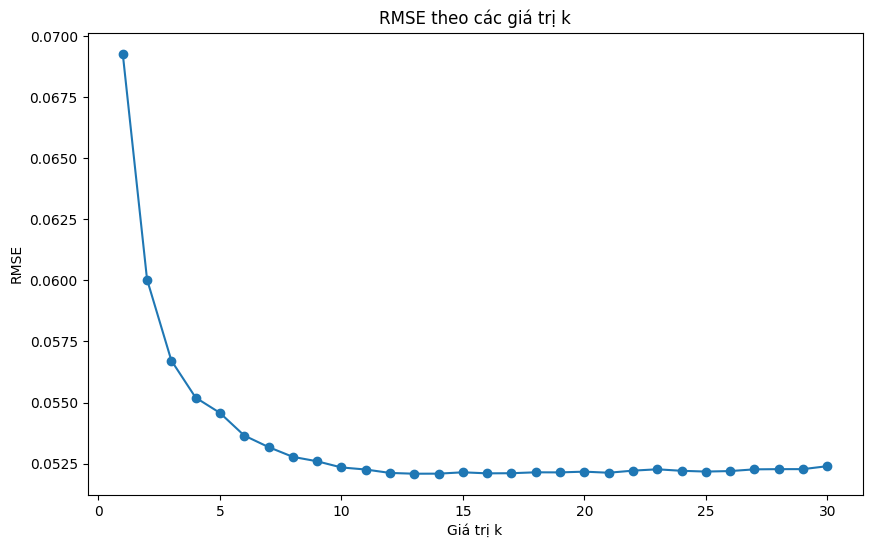

Giá trị k tối ưu: 13


In [51]:
optimal_k = find_optimal_k(X_train, y_train)

In [52]:
knn = KNeighborsRegressor(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=13)

In [53]:
y_pred = knn.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)


In [58]:
acctually_prices = data_test['meantemp'][:109]

In [59]:
# Tính Mean Squared Error
mse = mean_squared_error(acctually_prices, y_pred)
print(f"MSE: {mse}")

# Tính MAE
mae = mean_absolute_error(acctually_prices, y_pred)
print(f"MAE: {mae}")

#Tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
mape = calculate_mape(acctually_prices, y_pred)
print(f"MAPE: {mape}")

MSE: 12.419353189607678
MAE: 3.004119562364918
MAPE: 40.658399276324346


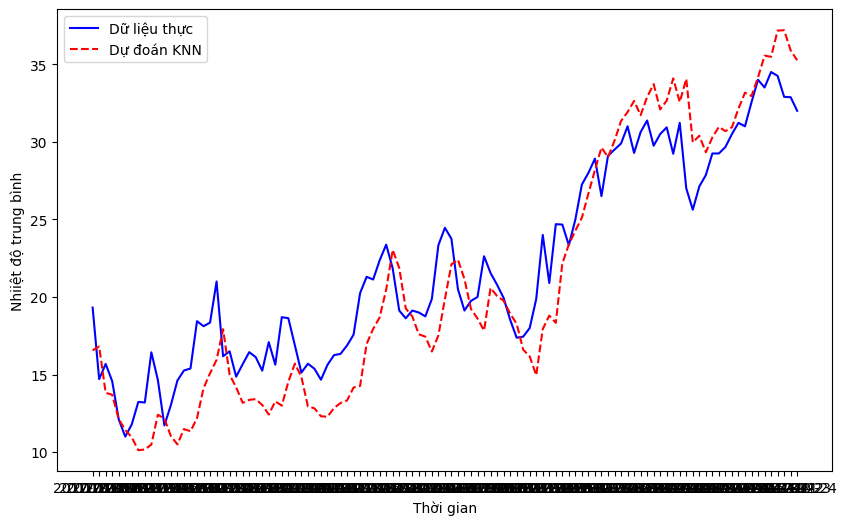

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(time_test[window_size:], data_test['meantemp'][window_size:], label='Dữ liệu thực', color='blue')
plt.plot(time_test[window_size:], y_pred, label='Dự đoán KNN', color='red', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('Nhiiệt độ trung bình')
plt.legend()
plt.show()